# Abstract
From time to time, I've asked friends how many cylinders their engine had out of curiosity, despite not being very interested in cars myself. Often, they say they don't know. Of course, many modern cars track the user's miles per gallon somewhere. The goal of this analysis is to see if I can accurately predict the number of cylinders in a car's engine by the miles per gallon it gets.

# Data
The data was downloaded from https://fueleconomy.gov/feg/download.shtml. It contains general automotive data for every model of car by year from 1984 to 2024. The data is collected and posted by the U.S. Department of Energy's Office of Energy Efficiency & Renewable Energy.

In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv('vehicles.csv')

C:\Users\theis\AppData\Local\Temp\ipykernel_18072\1939487813.py:3: DtypeWarning: Columns (72,74,75,77) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('vehicles.csv')


### Data Cleaning
To start, lets filter the data by purely regular gasoline cars, because the cylidner interpretation falls apart with elecrtic and hybrid cars. We also clean invalid and missing values.

In [2]:
data = data[data['fuelType1'] == 'Regular Gasoline']
data = data[data['cylinders'] > 0]
data = data.loc[:,['cylinders', 'comb08', 'VClass']]

### Visual

<Axes: xlabel='comb08', ylabel='Count'>

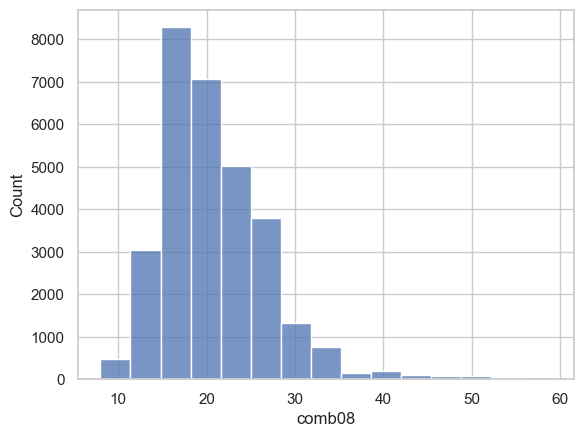

In [3]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_theme(style='whitegrid')
sns.histplot(data, x='comb08', bins=15)

<Axes: xlabel='cylinders', ylabel='comb08'>

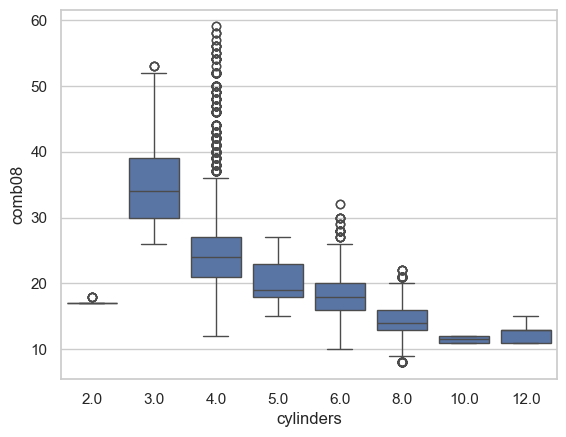

In [4]:
sns.boxplot(data=data, x='cylinders', y='comb08')

These results look reasonable, so we can continue onwards

# Methods
The first method we will employ is perhaps the most simple, an ANOVA test with all of the data

## ANOVA Test
We filter out all cylinders if they have less than 30 observations to avoid checking our assumption of normality.

In [5]:
data = data.sort_values(by='cylinders').astype({'cylinders': 'int'})
cyl_counts = [(cylinder,len(data[data['cylinders']==cylinder])) for cylinder in pd.unique(data['cylinders'])]
cylinder_datas = [data[data['cylinders'] == cyl[0]]['comb08'].rename(cyl[0])
                   for cyl in cyl_counts if cyl[1] > 30]
cyl_filtered = [cyl[0] for cyl in cyl_counts if cyl[1] > 30]
data_filtered = data[data['cylinders'].isin(cyl_filtered)]

Let's check our assumption of homogeneity of variance with Levene's test and checking the ratio of the smallest and largest standard deviations.

In [6]:
from scipy import stats
stats.levene(*cylinder_datas, center='mean')

LeveneResult(statistic=650.59067093809, pvalue=0.0)

In [7]:
import statistics
stdevs = [statistics.stdev(sample) for sample in cylinder_datas]
max(stdevs)/min(stdevs)

5.411608366210134

The data clearly lacks homogeneity of variance, as Levene's test is significant and the ratio of largest to smallest standard deviations is greater than 2. Thus, we use Welch's ANOVA for normal but non-homogeneous data

In [8]:
import pingouin as pg
pg.welch_anova(dv='comb08', between='cylinders', data=data_filtered)

,Source,ddof1,ddof2,F,p-unc,np2
0,cylinders,5,376.612178,7490.664426,0.0,0.523679


Clearly, with F=5363.59 and p~=0, we conclude that at least one cylinder type for gas cars get a significantly different combined city and highway miles per gallon than the rest.

### Tukey's HSD Post-Hoc
To determine which groups differ, we use Tukey's Honest Squared Difference Post-Hoc

In [9]:
tukey_hsd_test = stats.tukey_hsd(*cylinder_datas)

display(pd.DataFrame(tukey_hsd_test.pvalue, columns=cyl_filtered, index=cyl_filtered))

,3,4,5,6,8,12
3,1.0,0.0,0.0,0.0,0.000000,0.000000
4,0.0,1.0,0.0,0.0,0.000000,0.000000
5,0.0,0.0,1.0,0.0,0.000000,0.000000
6,0.0,0.0,0.0,1.0,0.000000,0.000000
8,0.0,0.0,0.0,0.0,1.000000,0.015183
12,0.0,0.0,0.0,0.0,0.015183,1.000000


As seen in the table above, all cylinders had significantly different mean MPG from other cylinders at $\alpha=0.05$. Let's revisit the boxplots from before, with the filtered data now.

## Confidence Intervals
Now, we compute simple confidence intervals to figure out which groups differ and what range allows us to be certain of a car's cylinder count. This should work. given the result of Tukey's HSD.

Text(0, 0.5, 'Cylinders')

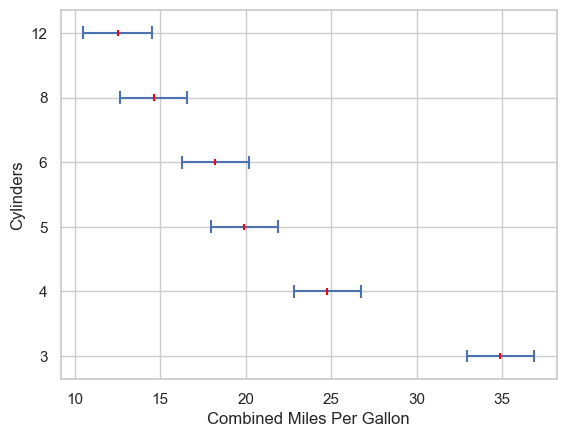

In [10]:
fig, ax = plt.subplots()
y=0
for s in cylinder_datas:
    y += 1
    xmin, xmax = stats.t.interval(0.95, len(s)-1, s.mean())
    ax.hlines(y,xmin,xmax)
    ax.vlines(xmin, y+.1, y-.1)
    ax.vlines(xmax, y+.1, y-.1)
    x = (xmin + xmax) / 2
    ax.vlines(x, y+.05, y-.05, colors='red')

ax.set_yticks([1,2,3,4,5,6], labels=cyl_filtered)
ax.set_xlabel('Combined Miles Per Gallon')
ax.set_ylabel('Cylinders')



Among the more common engine cylinder counts, being 4, 6, and 8 cylinders, we can be *fairly* certain of a car's cylinders based on its miles per gallon. Some uncertainty is seen with 6 and 8-cylinder cars, but neither mean falls within the other's 95% confidence interval, so we can still guess pretty well.  

## Ordinal Logistic Regression
To establish a model for prediction, we use Ordinal Logistic Regression to predict cylinders, as it is an ordinal categorical variable.

In [ ]:
from statsmodels.miscmodels.ordinal_model import OrderedModel
ordinal_model = OrderedModel(data_filtered['cylinders'], data_filtered['comb08'])
resid = ordinal_model.fit(method='bfgs')
resid.summary()

Optimization terminated successfully.
         Current function value: 0.717696
         Iterations: 35
         Function evaluations: 40
         Gradient evaluations: 40


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:              cylinders   Log-Likelihood:                -21794.
Model:                   OrderedModel   AIC:                         4.360e+04
Method:            Maximum Likelihood   BIC:                         4.365e+04
Date:                Tue, 28 Jan 2025                                         
Time:                        20:12:22                                         
No. Observations:               30367                                         
Df Residuals:                   30361                                         
Df Model:                           1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
comb08        -0.2906      0.002   -126.694      0.000      -0.295      -0.286
3/4          -12.0492      0.100   -120.679      0.000     -12.245     -11.853
4/5            1.7976      0.010    175.765      0.000       1.778       1.818
5/6           -2.6269      0.047    -55.987      0.000      -2.719      -2.535
6/8            0.5120      0.009     59.645      0.000       0.495       0.529
8/12           1.1062      0.020     55.108      0.000       1.067       1.146
==============================================================================
"""

Now, we compute the accuracy of the model 

In [12]:
predicted = ordinal_model.predict(resid.params)
predicted = pd.DataFrame(predicted, index=data_filtered.index, columns=['3','4','5','6','8','12'])

predictions = predicted.idxmax(axis=1).astype('int32')
predictions.name = 'predicted_cylinders'

data_filtered_predictions = data_filtered.join(predictions, how='inner')
accuracy = len(data_filtered_predictions[data_filtered_predictions['cylinders'] == data_filtered_predictions['predicted_cylinders']]) / len(data_filtered_predictions)
display(accuracy)

0.725985444726183

## Decision Trees
We create a decision tree with at most three questions using 'comb08' and 'VClass' to predict 'cylinders'. First, we need to convert 'VClass' to dummy variables since sklearn's decision tree does not support categorical predictors.

In [13]:
from sklearn import tree
data_dt = pd.concat([data_filtered.iloc[:,0:2], pd.get_dummies(data_filtered['VClass'])], axis='columns')
clf = tree.DecisionTreeClassifier(criterion="gini", max_depth=5)
clf = clf.fit(X=data_dt.iloc[:,1:], y=data_dt.iloc[:,0])

predictions_dt = clf.predict(data_dt.drop('cylinders', axis=1))

To judge the effectiveness of this model, we again compute the accuracy

In [14]:
predictions_dt = pd.Series(predictions_dt, index=data_filtered.index, name='predicted_dt_cylinders')
data_filtered_predictions_dt = data_filtered_predictions.join(predictions_dt, how='inner')
accuracy_dt = len(data_filtered_predictions_dt[data_filtered_predictions_dt['cylinders'] == data_filtered_predictions_dt['predicted_dt_cylinders']]) / len(data_filtered_predictions_dt)
display(accuracy_dt)

0.7607271050811737